In [1]:
%matplotlib inline
import matplotlib

In [2]:
import csv
import numpy as np
import pandas as pd
matplotlib.style.use('seaborn')
import matplotlib.pyplot as plt
from copy import deepcopy

In [3]:
cubic = ["W","V","K","Al","Cu","Pd"]
hcp = ["Ti","Re","Y"]
metals = cubic+hcp
semi = ["Si"]
insul = ["NaCl"]

In [4]:
def get_mean_data_kpd(method,elements,sub_method=None):
    """Gathers the convergence data for the given method, element, 
    and sub-method, i.e. 'sc' for the Froyen method, and places it
    in a pandas dataframe where each column is a different cell 
    size and each row is a different k-point density. The dataframe also
    contains the mean error per density and numbder of instances 
    the density occures.
    
    Args:
        methad (str): "Froyen", "Mueller", or "Aflow"
        elements (list of str): A list consisting of the desired 
            elements ("V", "W", "Cu", "Al", "K", "Pd", "Ti", "Y", "Re")
        sub_method (str, optional): The sampling scheme for the 
            Froyen method ("sc", "bcc", "fcc", "hcp"). A sub_method is
            required for the Froyen method and for any other method
            this should be None.
    
    Returns:
        outdf (pandas.dataframe): A pandas dataframe of the error in
            the calculated energy at each density (row) and supercell 
            (column) in addition to a column of the average error per
            density.
    """
    for el in elements:
        if el in ["Ti","Y","Re"]:
            sizes = range(1,8)
        else:
            sizes = range(1,12)
            
        for i in sizes:
            data = []
            kpd = []
            if sub_method is None:
                f = open("../data2/{0}/{1}_conv/{2}_atom_kpd_conv.csv".format(method,el,i),"r")
            else:
                f = open("../data2/{0}/{1}_conv/{2}_{3}_atom_kpd_conv.csv".format(method,el,i,sub_method),"r")
            reader = csv.reader(f,delimiter='\t')
            for row in reader:
                if float(row[0]) in kpd and float(row[1]) != 0:
                    loc = kpd.index(float(row[0]))
                    data[loc][1] = (data[loc][1]+float(row[1]))/2.
                elif float(row[1]) != 0:
                    kpd.append(float(row[0]))
                    point = [float(row[0]),float(row[1])]
                    data.append(point)
                    
            data = np.array(data)
            if len(data) >= 1:
                df = pd.DataFrame(data[:,1:],index=data[:,0])#,columns=[str(i)+' atom'])    
            else:
                print("Method: {0}, element: {1}, size: {2}".format(method,el,i))
                
            if i > 1 or el != elements[0]:
                outdf = pd.concat([outdf,df], axis=1)
            else:
                outdf = df

    outdf['mean'] = outdf.mean(axis=1) 
    outdf['count'] = outdf.apply(lambda x: x.count(), axis=1)
    return outdf

In [5]:
#method,elements,sub_method=None
M_metals = get_mean_data_kpd("Mueller",metals)
F_sc_metals = get_mean_data_kpd("Froyen",["W","V","K","Al","Cu","Pd"],sub_method="sc")
F_bcc_metals = get_mean_data_kpd("Froyen",["W","V","K","Al","Cu","Pd"],sub_method="bcc")
F_fcc_metals = get_mean_data_kpd("Froyen",["W","V","K","Al","Cu","Pd"],sub_method="fcc")
F_hcp_metals = get_mean_data_kpd("Froyen",["Ti","Re","Y"],sub_method="hcp")
A_metals = get_mean_data_kpd("Aflow",metals)

In [6]:
M_mean = np.transpose([M_metals.index.values,M_metals["mean"]])
A_mean = np.transpose([A_metals.index.values,A_metals["mean"]])
#F_mean = np.transpose([F_metals.index.values,F_metals["mean"]])

In [7]:
%%sh
pip install statsmodels

In [51]:
from statsmodels.nonparametric.smoothers_lowess import lowess
M_sm = 0.04
m_it = 0
M_smoothed = lowess(abs(M_mean[:,1]),M_mean[:,0],frac=M_sm,it=m_it)
#F_smoothed = lowess(abs(F_mean[:,1]),F_mean[:,0],frac=M_sm*len(M_mean)/len(F_mean),it=1)
A_smoothed = lowess(abs(A_mean[:,1]),A_mean[:,0],frac=M_sm*len(M_mean)/len(A_mean),it=m_it)

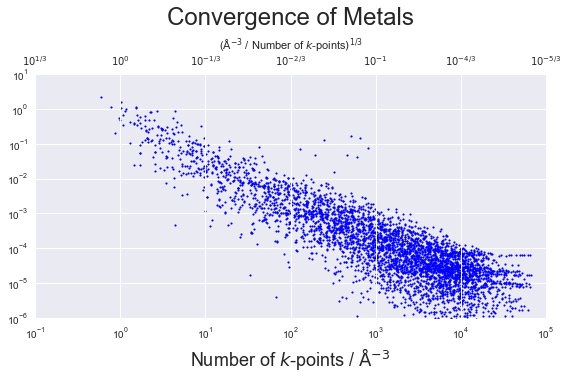

In [53]:
fig = plt.figure()
ax1 = fig.add_subplot(111)
ax2 = ax1.twiny()
ax1.scatter(M_mean[:,0],abs(M_mean[:,1]),label="General",marker="o",s=3,c='b')
ax1.set_xlabel("Number of $k$-points / $\mathrm{\AA}^{-3}$",fontsize=18)
ax1.set_xscale('log')

new_tick_locations = np.array([.1,1,10,100,1000,10000,100000,1000000])
def tick_function(X):
    V = 1/X
    return [np.log10(z) for z in V]
ax1.set_xlim(.1,100000)
ax2.set_xlim(ax1.get_xlim())
ax2.set_xticks(new_tick_locations)
#print(tick_function(new_tick_locations))
#print([i for i in ax2.get_xticklabels()])
#print([i for i in ax1.get_xticklabels()])
ax2.set_xlabel("($\mathrm{\AA}^{-3}$ / Number of $k$-points$)^{1/3}$")
ax2.set_xscale('log')
ax2.set_xticklabels(["$10^{0}$","$10^{1/3}$","$10^{0}$","$10^{-1/3}$",
                    "$10^{-2/3}$","$10^{-1}$","$10^{-4/3}$","$10^{-5/3}$"])
#plt.plot(M_smoothed[:,0],M_smoothed[:,1],c='c',label="General")
#plt.scatter(F_mean[:,0],abs(F_mean[:,1]),label="Froyen",marker="o",s=3,c='r')
#plt.plot(F_smoothed[:,0],F_smoothed[:,1],c='m',label="Froyen")
#plt.scatter(A_mean[:,0],abs(A_mean[:,1]),label="AFLOW",marker="o",s=3,c='g')
#plt.plot(A_smoothed[:,0],A_smoothed[:,1],c='white',label="AFLOW")
#plt.scatter(F_metals_scat[:,0],abs(F_metals_scat[:,1]),label="Froyen",marker="o",s=3,c='b')
#plt.scatter(A_metals_scat[:,0],abs(A_metals_scat[:,1]),label="MP",marker="o",s=3,c='saddlebrown')
#plt.axhline(y=1E-5, xmin=0, xmax=1, hold=None, c='k')
#plt.axhline(y=1E-3, xmin=0, xmax=1, hold=None, c='r')
plt.ylabel("Total energy error (eV)",fontsize=18)
plt.title("Convergence of Metals",fontsize=24,y=1.18)
plt.yscale('log')
plt.ylim(1E-6,1E1)
plt.xlim(1E-1,1E5)
plt.legend()
plt.tight_layout()
plt.savefig("/Users/wileymorgan/Desktop/2_axis_scatter.pdf")
plt.show()

In [196]:
def get_mean_data_ibzkpd(method,elements,sub_method=None):
    """Gathers the convergence data for the given method, element, 
    and sub-method, i.e. 'sc' for the Froyen method, and places it
    in a pandas dataframe where each column is a different cell 
    size and each row is a different irreducible k-point density. 
    The dataframe also contains the mean error per density and
    numbder of times the density occures.
    
    Args:
        methad (str): "Froyen", "Mueller", or "Aflow"
        elements (list of str): A list consisting of the desired 
            elements ("V", "W", "Cu", "Al", "K", "Pd", "Ti", "Y", "Re")
        sub_method (str, optional): The sampling scheme for the 
            Froyen method ("sc", "bcc", "fcc", "hcp"). A sub_method is
            required for the Froyen method and for any other method
            this should be None.
    
    Returns:
        outdf (pandas.dataframe): A pandas dataframe of the error in
            the calculated energy at each density (row) and supercell 
            (column) in addition to a column of the average error per
            density.
    """
    for el in elements:
        if el in ["Ti","Y","Re"]:
            sizes = range(1,8)
        else:
            sizes = range(1,12)
            
        for i in sizes:
            data = []
            kpd = []
            if sub_method is None:
                f = open("../data2/{0}/{1}_conv/{2}_atom_IBZKPTS_dese_conv.csv".format(method,el,i),"r")
            else:
                f = open("../data2/{0}/{1}_conv/{2}_{3}_atom_IBZKPTS_dese_conv.csv".format(method,el,i,sub_method),"r")
            reader = csv.reader(f,delimiter='\t')
            for row in reader:
                if float(row[0]) in kpd and float(row[1]) != 0:
                    loc = kpd.index(float(row[0]))
                    data[loc][1] = (data[loc][1]+float(row[1]))/2.
                elif float(row[1]) != 0:
                    kpd.append(float(row[0]))
                    point = [float(row[0]),float(row[1])]
                    data.append(point)
                    
            data = np.array(data)
            if len(data) >= 1:
                df = pd.DataFrame(data[:,1:],index=data[:,0])#,columns=[str(i)+' atom'])    
            else:
                print("Method: {0}, element: {1}, size: {2}".format(method,el,i))
                
            if i > 1 or el != elements[0]:
                outdf = pd.concat([outdf,df], axis=1)
            else:
                outdf = df

    outdf['mean'] = outdf.mean(axis=1) 
    outdf['count'] = outdf.apply(lambda x: x.count(), axis=1)
    return outdf

In [197]:
M_metals_ibz = get_mean_data_ibzkpd("Mueller",metals)
F_sc_metals_ibz = get_mean_data_ibzkpd("Froyen",cubic,sub_method="sc")
F_bcc_metals_ibz = get_mean_data_ibzkpd("Froyen",cubic,sub_method="bcc")
F_fcc_metals_ibz = get_mean_data_ibzkpd("Froyen",cubic,sub_method="fcc")
F_hcp_metals_ibz = get_mean_data_ibzkpd("Froyen",hcp,sub_method="hcp")
A_metals_ibz = get_mean_data_ibzkpd("Aflow",metals)

Method: Froyen, element: Cu, size: 3
Method: Froyen, element: Pd, size: 3
Method: Froyen, element: V, size: 1
Method: Froyen, element: V, size: 1
Method: Froyen, element: Cu, size: 3
Method: Froyen, element: Pd, size: 3
Method: Aflow, element: V, size: 1


In [198]:
M_metals_scat_ibz = make_scatter_plot_data(M_metals_ibz)
F_sc_metals_scat_ibz = make_scatter_plot_data(F_sc_metals_ibz)
F_bcc_metals_scat_ibz = make_scatter_plot_data(F_bcc_metals_ibz)
F_fcc_metals_scat_ibz = make_scatter_plot_data(F_fcc_metals_ibz)
F_hcp_metals_scat_ibz = make_scatter_plot_data(F_hcp_metals_ibz)
A_metals_scat_ibz = make_scatter_plot_data(A_metals_ibz)

In [199]:
F_metals_scat_ibz = np.concatenate((F_sc_metals_scat_ibz,F_bcc_metals_scat_ibz),axis=0)
F_metals_scat_ibz = np.concatenate((F_metals_scat_ibz,F_fcc_metals_scat_ibz),axis=0)
F_metals_scat_ibz = np.concatenate((F_metals_scat_ibz,F_hcp_metals_scat_ibz),axis=0)

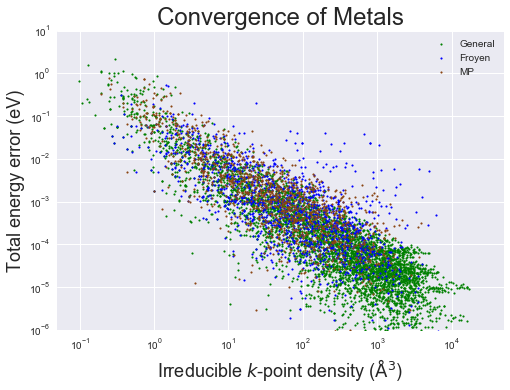

In [237]:
plt.scatter(M_metals_scat_ibz[:,0],abs(M_metals_scat_ibz[:,1]),label="General",marker="o",s=3,c='g')
plt.scatter(F_metals_scat_ibz[:,0],abs(F_metals_scat_ibz[:,1]),label="Froyen",marker="o",s=3,c='b')
plt.scatter(A_metals_scat_ibz[:,0],abs(A_metals_scat_ibz[:,1]),label="MP",marker="o",s=3,c='saddlebrown')
#plt.axhline(y=1E-5, xmin=0, xmax=1, hold=None, c='k')
#plt.axhline(y=1E-3, xmin=0, xmax=1, hold=None, c='r')
plt.ylabel("Total energy error (eV)",fontsize=18)
plt.xlabel("Irreducible $k$-point density ($\mathrm{\AA}^{3}$)",fontsize=18)
plt.title("Convergence of Metals",fontsize=24)
plt.yscale('log')
plt.xscale('log')
plt.ylim(1E-6,1E1)
plt.xlim(5E-2,5E4)
plt.legend()
plt.savefig("../plots/All_metals_irreducible_comb.pdf")
plt.show()

In [244]:
np.savetxt("/Users/wileymorgan/Desktop/Mueller_metals_kpd.csv",M_metals_scat,delimiter="\t")
np.savetxt("/Users/wileymorgan/Desktop/Froyen_metals_kpd.csv",F_metals_scat,delimiter="\t")
np.savetxt("/Users/wileymorgan/Desktop/Aflow_metals_kpd.csv",A_metals_scat,delimiter="\t")
np.savetxt("/Users/wileymorgan/Desktop/Froyen_sc_metals_kpd.csv",F_sc_metals_scat,delimiter="\t")
np.savetxt("/Users/wileymorgan/Desktop/Froyen_bcc_metals_kpd.csv",F_bcc_metals_scat,delimiter="\t")
np.savetxt("/Users/wileymorgan/Desktop/Froyen_fcc_metals_kpd.csv",F_fcc_metals_scat,delimiter="\t")
np.savetxt("/Users/wileymorgan/Desktop/Froyen_hcp_metals_kpd.csv",F_hcp_metals_scat,delimiter="\t")
np.savetxt("/Users/wileymorgan/Desktop/Mueller_metals_irreducible_kpd.csv",M_metals_scat_ibz,delimiter="\t")
np.savetxt("/Users/wileymorgan/Desktop/Froyen_metals_irreducible_kpd.csv",F_metals_scat_ibz,delimiter="\t")
np.savetxt("/Users/wileymorgan/Desktop/Aflow_metals_irreducible_kpd.csv",A_metals_scat_ibz,delimiter="\t")
np.savetxt("/Users/wileymorgan/Desktop/Froyen_sc_metals_irreducible_kpd.csv",F_sc_metals_scat_ibz,delimiter="\t")
np.savetxt("/Users/wileymorgan/Desktop/Froyen_bcc_metals_irreducible_kpd.csv",F_bcc_metals_scat_ibz,delimiter="\t")
np.savetxt("/Users/wileymorgan/Desktop/Froyen_fcc_metals_irreducible_kpd.csv",F_fcc_metals_scat_ibz,delimiter="\t")
np.savetxt("/Users/wileymorgan/Desktop/Froyen_hcp_metals_irreducible_kpd.csv",F_hcp_metals_scat_ibz,delimiter="\t")

In [260]:
from statsmodels.nonparametric.smoothers_lowess import lowess
M_sm = 0.0775
M_smoothed_ibz = lowess(abs(M_metals_scat_ibz[:,1]),abs(M_metals_scat_ibz[:,0]),frac=M_sm,it=1)
F_smoothed_ibz = lowess(abs(F_metals_scat_ibz[:,1]),abs(F_metals_scat_ibz[:,0]),frac=M_sm*len(M_mean)/len(F_mean),it=1)
A_smoothed_ibz = lowess(abs(A_metals_scat_ibz[:,1]),abs(A_metals_scat_ibz[:,0]),frac=M_sm*len(M_mean)/len(A_mean),it=1)

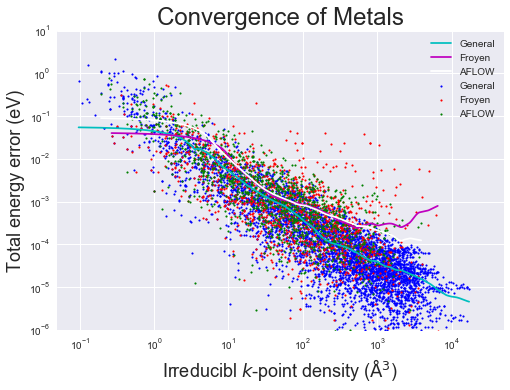

In [261]:
plt.scatter(M_metals_scat_ibz[:,0],abs(M_metals_scat_ibz[:,1]),label="General",marker="o",s=3,c='b')
plt.plot(M_smoothed_ibz[:,0],M_smoothed_ibz[:,1],c='c',label="General")
plt.scatter(F_metals_scat_ibz[:,0],abs(F_metals_scat_ibz[:,1]),label="Froyen",marker="o",s=3,c='r')
plt.plot(F_smoothed_ibz[:,0],F_smoothed_ibz[:,1],c='m',label="Froyen")
plt.scatter(A_metals_scat_ibz[:,0],abs(A_metals_scat_ibz[:,1]),label="AFLOW",marker="o",s=3,c='g')
plt.plot(A_smoothed_ibz[:,0],A_smoothed_ibz[:,1],c='white',label="AFLOW")
#plt.scatter(F_metals_scat[:,0],abs(F_metals_scat[:,1]),label="Froyen",marker="o",s=3,c='b')
#plt.scatter(A_metals_scat[:,0],abs(A_metals_scat[:,1]),label="MP",marker="o",s=3,c='saddlebrown')
#plt.axhline(y=1E-5, xmin=0, xmax=1, hold=None, c='k')
#plt.axhline(y=1E-3, xmin=0, xmax=1, hold=None, c='r')
plt.ylabel("Total energy error (eV)",fontsize=18)
plt.xlabel("Irreducibl $k$-point density ($\mathrm{\AA}^{3}$)",fontsize=18)
plt.title("Convergence of Metals",fontsize=24)
plt.yscale('log')
plt.xscale('log')
plt.ylim(1E-6,1E1)
plt.xlim(5E-2,5E4)
plt.legend()
plt.savefig("/Users/wileymorgan/Desktop/Irreducbile_Lowess_smoothing.pdf")
plt.show()

In [300]:
def single_atom_scat(el):
    data = []
    kpd = []
    f = open("../data2/{0}_conv/1_density_atom_convergence.csv".format(el),"r")
    reader = csv.reader(f,delimiter='\t')
    for row in reader:
        if float(row[0]) in kpd:
            loc = kpd.index(float(row[0]))
            data[loc][1] = (data[loc][1]+float(row[1]))/2.
        else:
            kpd.append(float(row[0]))
            point = [float(row[0]),float(row[1])]
            data.append(point)
    
    if len(data) > 0:
        data = np.array(data)
    return data

In [110]:
def make_scatter_plot_data(data_frame):
    rows = np.asarray(data_frame.index)
    
    data = []
    for row in rows:
        temp = data_frame.ix[:,data_frame.columns.difference(["mean","count"])].loc[row].dropna().values
        for t in temp:
            data.append([float(row),t])
            
    return np.array(data)
        

In [240]:
M_metals_scat = make_scatter_plot_data(M_metals)
F_sc_metals_scat = make_scatter_plot_data(F_sc_metals)
F_bcc_metals_scat = make_scatter_plot_data(F_bcc_metals)
F_fcc_metals_scat = make_scatter_plot_data(F_fcc_metals)
F_hcp_metals_scat = make_scatter_plot_data(F_hcp_metals)
A_metals_scat = make_scatter_plot_data(A_metals)

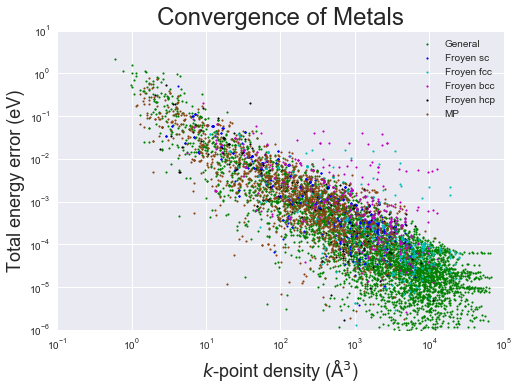

In [242]:
plt.scatter(M_metals_scat[:,0],abs(M_metals_scat[:,1]),label="General",marker="o",s=3,c='g')
plt.scatter(F_sc_metals_scat[:,0],abs(F_sc_metals_scat[:,1]),label="Froyen sc",marker="o",s=3,c='b')
plt.scatter(F_fcc_metals_scat[:,0],abs(F_fcc_metals_scat[:,1]),label="Froyen fcc",marker="o",s=3,c='c')
plt.scatter(F_bcc_metals_scat[:,0],abs(F_bcc_metals_scat[:,1]),label="Froyen bcc",marker="o",s=3,c='m')
plt.scatter(F_hcp_metals_scat[:,0],abs(F_hcp_metals_scat[:,1]),label="Froyen hcp",marker="o",s=3,c='k')
plt.scatter(A_metals_scat[:,0],abs(A_metals_scat[:,1]),label="MP",marker="o",s=3,c='saddlebrown')
#plt.axhline(y=1E-5, xmin=0, xmax=1, hold=None, c='k')
#plt.axhline(y=1E-3, xmin=0, xmax=1, hold=None, c='r')
plt.ylabel("Total energy error (eV)",fontsize=18)
plt.xlabel("$k$-point density ($\mathrm{\AA}^{3}$)",fontsize=18)
plt.title("Convergence of Metals",fontsize=24)
plt.yscale('log')
plt.xscale('log')
plt.ylim(1E-6,1E1)
plt.xlim(1E-1,1E5)
plt.legend()
plt.savefig("../plots/All_metals_comb.pdf")
plt.show()

In [21]:
print(len(M_metals_scat),len(A_metals_scat),len(F_metals_scat))
print(len(M_metals_scat)+len(A_metals_scat)+len(F_metals_scat))

(4553, 1309, 1290)
7152


In [13]:
#metals = ["Al","Cu","K","Pd","V","W","Ti","Y","Re"]
Al_full = get_mean_data_full(["Al"])
Al_scat = make_scatter_plot_data(Al_full)
Al_1 = single_atom_scat("Al")
Cu_full = get_mean_data_full(["Cu"])
Cu_scat = make_scatter_plot_data(Cu_full)
Cu_1 = single_atom_scat("Cu")
K_full = get_mean_data_full(["K"])
K_scat = make_scatter_plot_data(K_full)
K_1 = single_atom_scat("K")
Pd_full = get_mean_data_full(["Pd"])
Pd_scat = make_scatter_plot_data(Pd_full)
Pd_1 = single_atom_scat("Pd")
V_full = get_mean_data_full(["V"])
V_scat = make_scatter_plot_data(V_full)
V_1 = single_atom_scat("K")
W_full = get_mean_data_full(["W"])
W_scat = make_scatter_plot_data(W_full)
W_1 = single_atom_scat("W")
Ti_full = get_mean_data_full(["Ti"])
Ti_scat = make_scatter_plot_data(Ti_full)
Ti_1 = single_atom_scat("Ti")
Y_full = get_mean_data_full(["Y"])
Y_scat = make_scatter_plot_data(Y_full)
Y_1 = single_atom_scat("Y")
Re_full = get_mean_data_full(["Re"])
Re_scat = make_scatter_plot_data(Re_full)
Re_1 = single_atom_scat("Re")
Si_full = get_mean_data_full(["Si"])
Si_scat = make_scatter_plot_data(Si_full)
Si_1 = single_atom_scat("Si")
NaCl_full = get_mean_data_full(["NaCl"])
NaCl_scat = make_scatter_plot_data(NaCl_full)
NaCl_1 = single_atom_scat("NaCl")

('element', 'Si', 'size', 7)
('element', 'NaCl', 'size', 5)
('element', 'NaCl', 'size', 6)
('element', 'NaCl', 'size', 7)


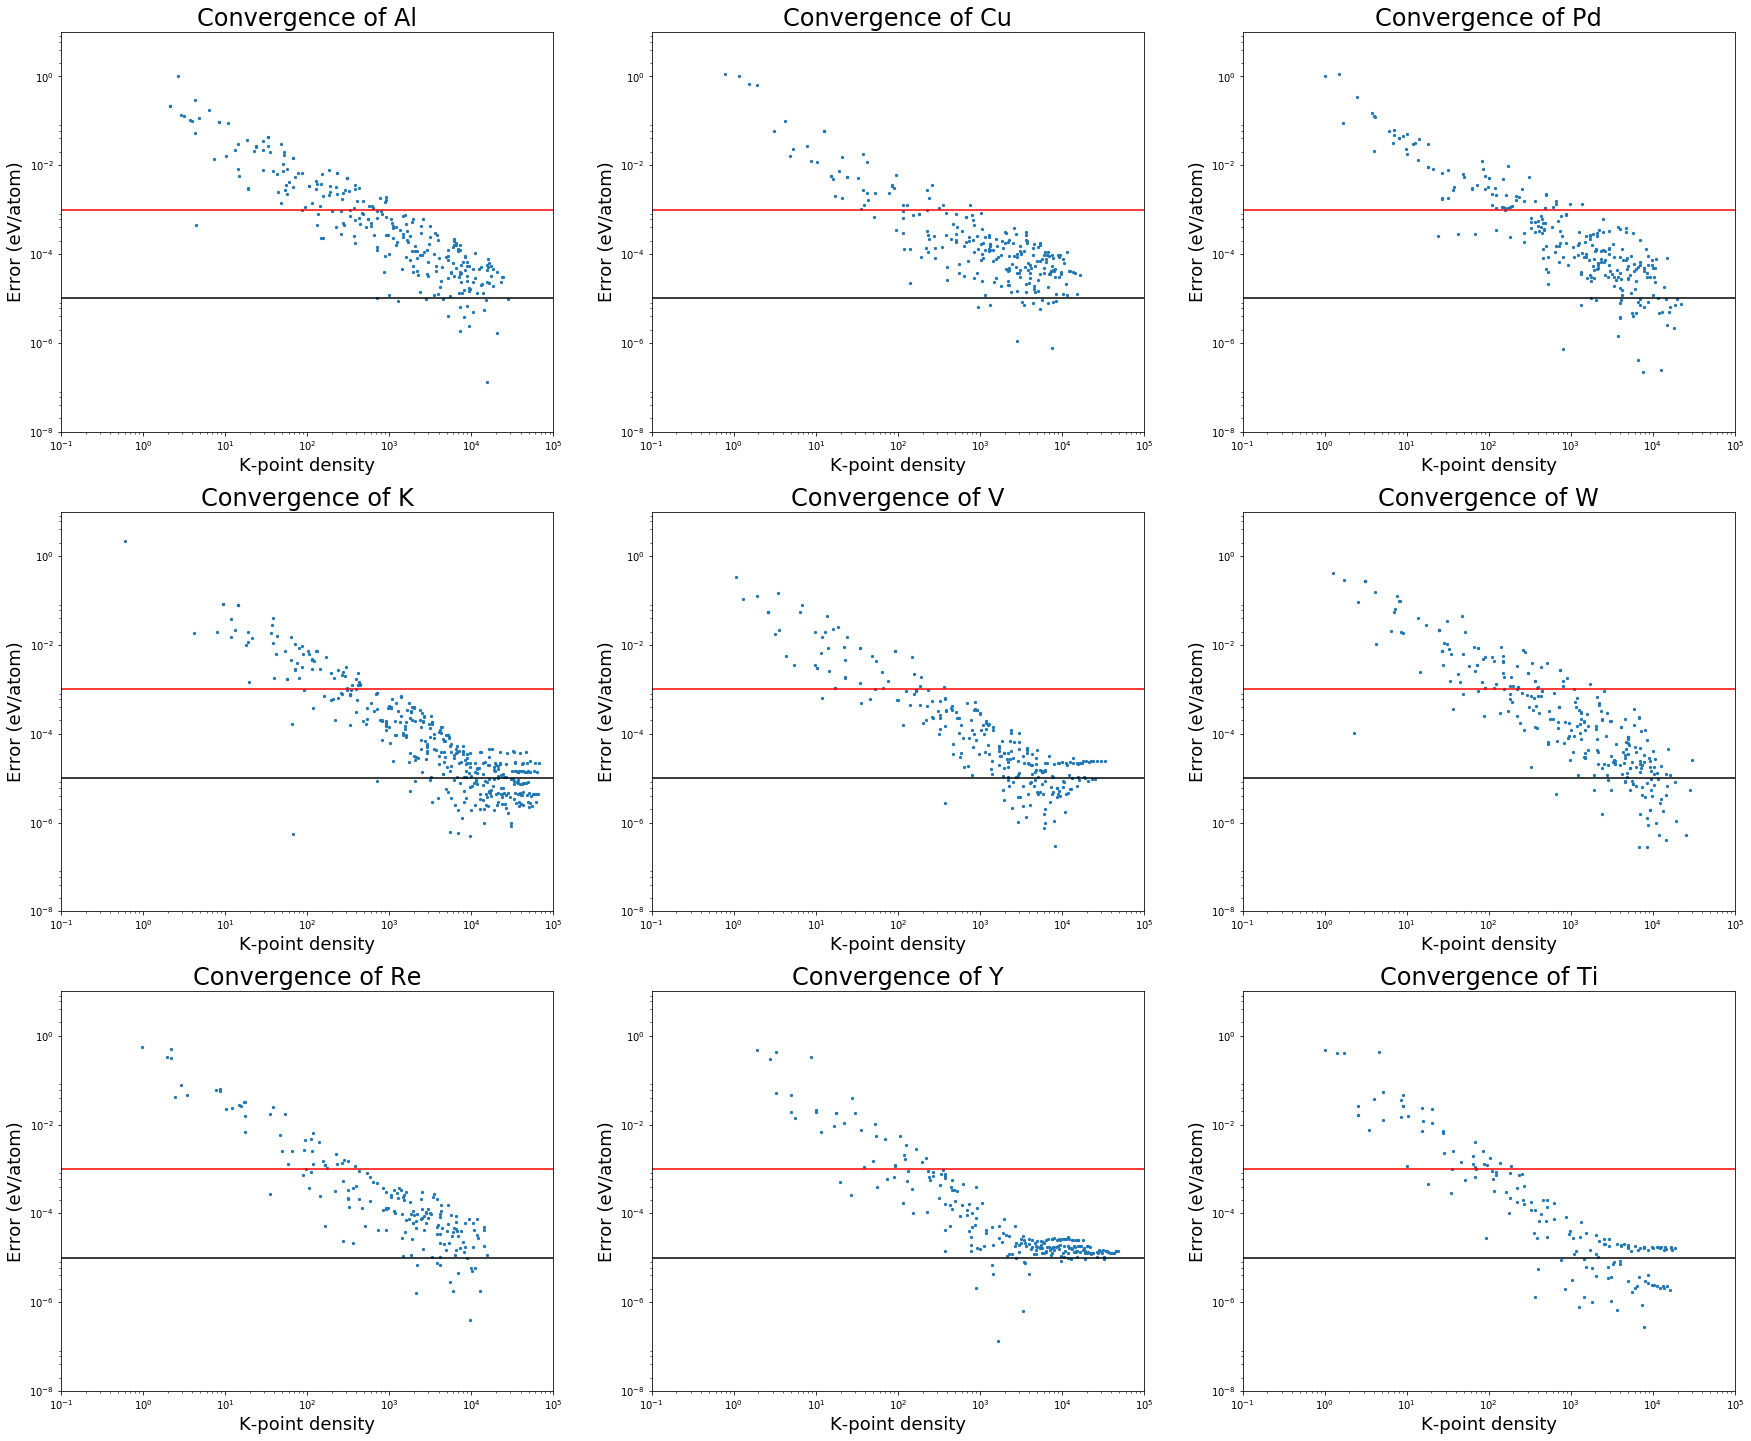

In [44]:
plt.figure(figsize=(30,25))
plt.subplot(3,3,1)
plt.scatter(Al_scat[:,0],Al_scat[:,1],label="Al",s=5)
#plt.scatter(Al_1[:,0],Al_1[:,1],label="Al 1 atom",s=3)
plt.axhline(y=1E-5, xmin=0, xmax=1, hold=None, c='k')
plt.axhline(y=1E-3, xmin=0, xmax=1, hold=None, c='r')
plt.ylabel("Error (eV/atom)",fontsize=18)
plt.xlabel("K-point density",fontsize=18)
plt.title("Convergence of Al",fontsize=24)
plt.yscale('log')
plt.xscale('log')
plt.ylim(1E-8,1E1)
plt.xlim(1E-1,1E5)
plt.subplot(3,3,2)
plt.scatter(Cu_scat[:,0],Cu_scat[:,1],label="Cu",s=5)
#plt.scatter(Cu_1[:,0],Cu_1[:,1],label="Cu 1 atom",s=3)
plt.axhline(y=1E-5, xmin=0, xmax=1, hold=None, c='k')
plt.axhline(y=1E-3, xmin=0, xmax=1, hold=None, c='r')
plt.ylabel("Error (eV/atom)",fontsize=18)
plt.xlabel("K-point density",fontsize=18)
plt.title("Convergence of Cu",fontsize=24)
plt.yscale('log')
plt.xscale('log')
plt.ylim(1E-8,1E1)
plt.xlim(1E-1,1E5)
plt.subplot(3,3,3)
plt.scatter(Pd_scat[:,0],Pd_scat[:,1],label="Pd",s=5)
#plt.scatter(Pd_1[:,0],Pd_1[:,1],label="Pd 1 atom",s=3)
plt.axhline(y=1E-5, xmin=0, xmax=1, hold=None, c='k')
plt.axhline(y=1E-3, xmin=0, xmax=1, hold=None, c='r')
plt.ylabel("Error (eV/atom)",fontsize=18)
plt.xlabel("K-point density",fontsize=18)
plt.title("Convergence of Pd",fontsize=24)
plt.yscale('log')
plt.xscale('log')
plt.ylim(1E-8,1E1)
plt.xlim(1E-1,1E5)
plt.subplot(3,3,4)
plt.scatter(K_scat[:,0],K_scat[:,1],label="K",s=5)
#plt.scatter(K_1[:,0],K_1[:,1],label="K 1 atom",s=3)
plt.axhline(y=1E-5, xmin=0, xmax=1, hold=None, c='k')
plt.axhline(y=1E-3, xmin=0, xmax=1, hold=None, c='r')
plt.ylabel("Error (eV/atom)",fontsize=18)
plt.xlabel("K-point density",fontsize=18)
plt.title("Convergence of K",fontsize=24)
plt.yscale('log')
plt.xscale('log')
plt.ylim(1E-8,1E1)
plt.xlim(1E-1,1E5)
plt.subplot(3,3,5)
plt.scatter(V_scat[:,0],V_scat[:,1],label="V",s=5)
#plt.scatter(V_1[:,0],V_1[:,1],label="V 1 atom",s=3)
plt.axhline(y=1E-5, xmin=0, xmax=1, hold=None, c='k')
plt.axhline(y=1E-3, xmin=0, xmax=1, hold=None, c='r')
plt.ylabel("Error (eV/atom)",fontsize=18)
plt.xlabel("K-point density",fontsize=18)
plt.title("Convergence of V",fontsize=24)
plt.yscale('log')
plt.xscale('log')
plt.ylim(1E-8,1E1)
plt.xlim(1E-1,1E5)
plt.subplot(3,3,6)
plt.scatter(W_scat[:,0],W_scat[:,1],label="W",s=5)
#plt.scatter(W_1[:,0],W_1[:,1],label="W 1 atom",s=3)
plt.axhline(y=1E-5, xmin=0, xmax=1, hold=None, c='k')
plt.axhline(y=1E-3, xmin=0, xmax=1, hold=None, c='r')
plt.ylabel("Error (eV/atom)",fontsize=18)
plt.xlabel("K-point density",fontsize=18)
plt.title("Convergence of W",fontsize=24)
plt.yscale('log')
plt.xscale('log')
plt.ylim(1E-8,1E1)
plt.xlim(1E-1,1E5)
plt.subplot(3,3,7)
plt.scatter(Re_scat[:,0],Re_scat[:,1],label="Re",s=5)
#plt.scatter(Re_1[:,0],Re_1[:,1],label="Re 1 atom",s=3)
plt.axhline(y=1E-5, xmin=0, xmax=1, hold=None, c='k')
plt.axhline(y=1E-3, xmin=0, xmax=1, hold=None, c='r')
plt.ylabel("Error (eV/atom)",fontsize=18)
plt.xlabel("K-point density",fontsize=18)
plt.title("Convergence of Re",fontsize=24)
plt.yscale('log')
plt.xscale('log')
plt.ylim(1E-8,1E1)
plt.xlim(1E-1,1E5)
plt.subplot(3,3,8)
plt.scatter(Y_scat[:,0],Y_scat[:,1],label="Y",s=5)
#plt.scatter(Y_1[:,0],Y_1[:,1],label="Y 1 atom",s=3)
plt.axhline(y=1E-5, xmin=0, xmax=1, hold=None, c='k')
plt.axhline(y=1E-3, xmin=0, xmax=1, hold=None, c='r')
plt.ylabel("Error (eV/atom)",fontsize=18)
plt.xlabel("K-point density",fontsize=18)
plt.title("Convergence of Y",fontsize=24)
plt.yscale('log')
plt.xscale('log')
plt.ylim(1E-8,1E1)
plt.xlim(1E-1,1E5)
plt.subplot(3,3,9)
plt.scatter(Ti_scat[:,0],Ti_scat[:,1],label="Ti",s=5)
#plt.scatter(Ti_1[:,0],Ti_1[:,1],label="Ti 1 atom",s=3)
plt.axhline(y=1E-5, xmin=0, xmax=1, hold=None, c='k')
plt.axhline(y=1E-3, xmin=0, xmax=1, hold=None, c='r')
plt.ylabel("Error (eV/atom)",fontsize=18)
plt.xlabel("K-point density",fontsize=18)
plt.title("Convergence of Ti",fontsize=24)
plt.yscale('log')
plt.xscale('log')
plt.ylim(1E-8,1E1)
plt.xlim(1E-1,1E5)
plt.savefig("../plots/metal_dense_conv_by_element.pdf")
plt.show()

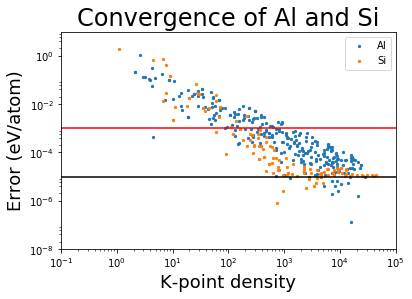

In [43]:
plt.scatter(Al_scat[:,0],Al_scat[:,1],label="Al",s=5)
#plt.scatter(Ti_scat[:,0],Ti_scat[:,1],label="Ti",s=3)
#plt.scatter(Cu_scat[:,0],Cu_scat[:,1],label="Cu",s=3)
#plt.scatter(Pd_scat[:,0],Pd_scat[:,1],label="Pd",s=3)
#plt.scatter(Re_scat[:,0],Re_scat[:,1],label="Re",s=3)
#plt.scatter(K_scat[:,0],K_scat[:,1],label="K",s=3)
#plt.scatter(V_scat[:,0],V_scat[:,1],label="V",s=3)
#plt.scatter(W_scat[:,0],W_scat[:,1],label="W",s=3)
#plt.scatter(Y_scat[:,0],Y_scat[:,1],label="Y",s=3)
plt.scatter(Si_scat[:,0],Si_scat[:,1],label="Si",s=5)
plt.axhline(y=1E-5, xmin=0, xmax=1, hold=None, c='k')
plt.axhline(y=1E-3, xmin=0, xmax=1, hold=None, c='r')
plt.ylabel("Error (eV/atom)",fontsize=18)
plt.xlabel("K-point density",fontsize=18)
plt.title("Convergence of Al and Si",fontsize=24)
plt.yscale('log')
plt.xscale('log')
plt.ylim(1E-8,10)
plt.xlim(1E-1,1E5)
plt.legend(loc='upper right')
plt.savefig('/Users/wileymorgan/Desktop/Al_Si.pdf')
plt.show()

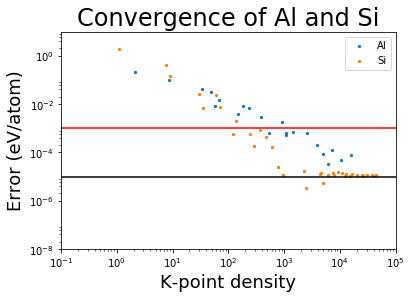

In [46]:
plt.scatter(Al_1[:,0],Al_1[:,1],label="Al",s=5)
plt.scatter(Si_1[:,0],Si_1[:,1],label="Si",s=5)
plt.axhline(y=1E-5, xmin=0, xmax=1, hold=None, c='k')
plt.axhline(y=1E-3, xmin=0, xmax=1, hold=None, c='r')
plt.ylabel("Error (eV/atom)",fontsize=18)
plt.xlabel("K-point density",fontsize=18)
plt.title("Convergence of Al and Si",fontsize=24)
plt.yscale('log')
plt.xscale('log')
plt.ylim(1E-8,10)
plt.xlim(1E-1,1E5)
plt.legend(loc='upper right')
plt.savefig('/Users/wileymorgan/Desktop/Al_Si.pdf')
plt.show()

In [137]:
valid_ks = [4, 32, 108, 256, 500, 864, 1024, 2048, 2000, 4000, 5324, 5488, 8788, 8192, 16384]

j_ks = []
m_j_ks = []
v54_ks = []
ks_u = []

f = open('../data2/Si_1/Si_Mueller_Rectangles')
reader = csv.reader(f,delimiter=' ')
for row in reader:
    if int(row[4]) in valid_ks:
        if int(row[4]) not in ks_u:
            ks_u.append(int(row[4]))
            j_ks.append([int(row[4]),float(row[3])])

ks_u = []
f = open('../data2/Si_1/Si_j_conv.csv')
reader = csv.reader(f,delimiter='\t')
for row in reader:
    if int(row[0]) in valid_ks:
        if int(row[0]) not in ks_u:
            ks_u.append(int(row[0]))
            m_j_ks.append([int(row[0]),float(row[1])])

ks_u = []
f = open('../data2/Si_1/Si_j_V54_conv.csv')
reader = csv.reader(f,delimiter='\t')
for row in reader:
    if int(row[0]) in valid_ks:
        if int(row[0]) not in ks_u:
            ks_u.append(int(row[0]))
            v54_ks.append([int(row[0]),float(row[1])])
            
v54_ks = np.array(v54_ks)
j_ks = np.array(j_ks)
m_j_ks = np.array(m_j_ks)

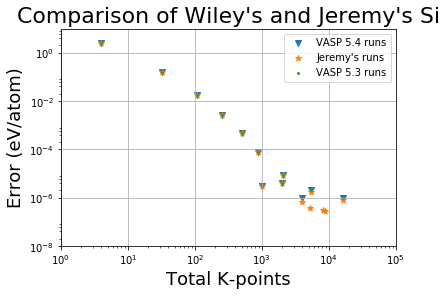

In [101]:
plt.scatter(v54_ks[:,0],v54_ks[:,1],label='VASP 5.4 runs',marker='v')
plt.scatter(j_ks[:,0],j_ks[:,1],label="Jeremy's runs",marker='*')
plt.scatter(m_j_ks[:,0],m_j_ks[:,1],label="VASP 5.3 runs",s=4)
plt.yscale('log')
plt.xscale('log')
plt.ylim(1E-8,10)
plt.xlim(1E0,1E5)
plt.legend()
plt.grid()
plt.title("Comparison of Wiley's and Jeremy's Si",fontsize=22)
plt.ylabel("Error (eV/atom)",fontsize=18)
plt.xlabel("Total K-points",fontsize=18)
plt.savefig('/Users/wileymorgan/Desktop/Si_comparison.pdf')
plt.show()

In [138]:
ks_u = []
m_j_ks_all = []
f = open('../data2/Si_1/Si_j_conv.csv')
reader = csv.reader(f,delimiter='\t')
for row in reader:
    if int(row[0]) not in ks_u:
        ks_u.append(int(row[0]))
        m_j_ks_all.append([int(row[0]),float(row[1])])
m_j_ks_all = np.array(m_j_ks_all)

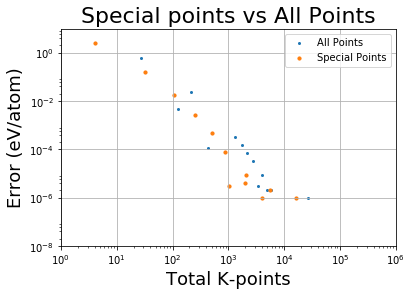

In [144]:
plt.scatter(m_j_ks_all[:,0],m_j_ks_all[:,1],label="All Points",s=4)
plt.scatter(m_j_ks[:,0],m_j_ks[:,1],label="Special Points",s=10)
plt.yscale('log')
plt.xscale('log')
plt.ylim(1E-8,10)
plt.xlim(1E0,1E6)
plt.legend()
plt.grid()
plt.title("Special points vs All Points",fontsize=22)
plt.ylabel("Error (eV/atom)",fontsize=18)
plt.xlabel("Total K-points",fontsize=18)
plt.savefig('/Users/wileymorgan/Desktop/Si_special_points.pdf')
plt.show()

In [116]:
sc_a = [4*n**3 for n in range(1,41)]
fcc_a = [n**3 for n in range(1,61)]
bcc_a = [16*n**3 for n in range(1,26)]

In [315]:
sc = []
fcc = []
bcc = []
ks_u = []
f = open('../data2/Si_1/Si_j_conv.csv')
reader = csv.reader(f,delimiter='\t')
for row in reader:
    if int(row[0]) not in ks_u and abs(float(row[1]))>0:
        ks_u.append(int(row[0]))
        if int(row[0]) in sc_a:            
            sc.append([int(row[0]),abs(float(row[1]))])
        elif int(row[0]) in fcc_a:
            fcc.append([int(row[0]),abs(float(row[1]))]) 
        elif int(row[0]) in bcc_a:
            bcc.append([int(row[0]),abs(float(row[1]))])
        else:
            print(row)
sc.sort(key=lambda x: x[0])
bcc.sort(key=lambda x: x[0])
fcc.sort(key=lambda x: x[0])
sc = np.array(sc)
bcc = np.array(bcc)
fcc = np.array(fcc)

In [132]:
def single_atom_scat_2(el):
    sc = []
    bcc = []
    fcc = []
    kpd = []
    f = open("../data2/{0}_conv/1_total_kps_atom_convergence.csv".format(el),"r")
    reader = csv.reader(f,delimiter='\t')
    for row in reader:
        if int(row[0]) not in kpd:
            kpd.append(int(row[0]))
            if int(row[0]) in sc_a:
                sc.append([int(row[0]),abs(float(row[1]))])
            elif int(row[0]) in fcc_a:
                fcc.append([int(row[0]),abs(float(row[1]))])
            elif int(row[0]) in bcc_a:
                bcc.append([int(row[0]),abs(float(row[1]))])
            else:
                print(row)
                break
    return np.array(sc), np.array(fcc), np.array(bcc)

In [159]:
al_sc, al_fcc, al_bcc = single_atom_scat_2("Al")
cu_sc, cu_fcc, cu_bcc = single_atom_scat_2("Cu")
pd_sc, pd_fcc, pd_bcc = single_atom_scat_2("Pd")

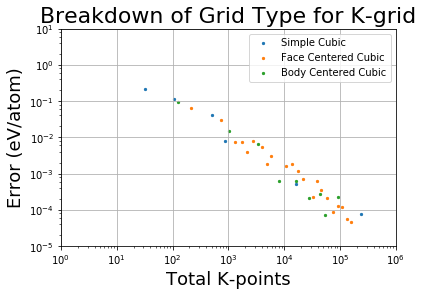

In [156]:
plt.scatter(al_sc[:,0],al_sc[:,1],label="Simple Cubic",s=5)
plt.scatter(al_fcc[:,0],al_fcc[:,1],label="Face Centered Cubic",s=5)
plt.scatter(al_bcc[:,0],al_bcc[:,1],label="Body Centered Cubic",s=5)
plt.yscale('log')
plt.xscale('log')
plt.ylim(1E-5,10)
plt.xlim(1E0,1E6)
plt.legend()
plt.grid()
plt.title("Breakdown of Grid Type for K-grid",fontsize=22)
plt.ylabel("Error (eV/atom)",fontsize=18)
plt.xlabel("Total K-points",fontsize=18)
plt.savefig('/Users/wileymorgan/Desktop/Al_grid_type.pdf')
plt.show()

In [226]:
ks_u = []
m_j_ks_all = []
f = open('../data2/Si_1/Si_j_conv.csv')
reader = csv.reader(f,delimiter='\t')
for row in reader:
    if int(row[0]) not in ks_u:
        ks_u.append(int(row[0]))
        if abs(float(row[1])) >0:
            m_j_ks_all.append([int(row[0]),abs(float(row[1]))])
m_j_ks_all.sort(key=lambda x: x[0])
m_j_ks_all = np.array(m_j_ks_all)

In [266]:
sc_full = []
bcc_full = []
fcc_full = []
all_grids = []

f = open('../data2/Si_by_grid/sc_conv.csv')
reader = csv.reader(f,delimiter='\t')
for row in reader:
    sc_full.append([int(row[0]),float(row[1])])
    if float(row[1]) > 1E-10:
        all_grids.append([int(row[0]),float(row[1])])
    
f = open('../data2/Si_by_grid/bcc_conv.csv')
reader = csv.reader(f,delimiter='\t')
for row in reader:
    bcc_full.append([int(row[0]),float(row[1])])
    if float(row[1]) > 1E-10:
        all_grids.append([int(row[0]),float(row[1])])
    
f = open('../data2/Si_by_grid/fcc_conv.csv')
reader = csv.reader(f,delimiter='\t')
for row in reader:
    fcc_full.append([int(row[0]),float(row[1])])
    if float(row[1]) > 1E-10:
        all_grids.append([int(row[0]),float(row[1])])
    
all_grids.sort(key=lambda x: x[0])
sc_full = np.array(sc_full)
bcc_full = np.array(bcc_full)
fcc_full = np.array(fcc_full)
all_grids = np.array(all_grids)

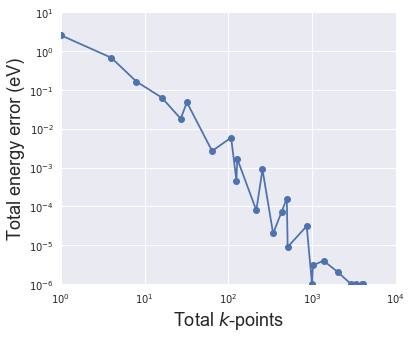

In [314]:
plt.figure(figsize=(6,5))
plt.plot(all_grids[:,0],all_grids[:,1],marker='o')
#plt.plot(m_j_ks_all[:,0],m_j_ks_all[:,1])
plt.yscale('log')
plt.xscale('log')
plt.ylim(1E-6,10)
plt.xlim(1E0,1E4)
plt.legend()
#plt.grid()
#plt.title("Si convergence",fontsize=22)
plt.ylabel("Total energy error (eV)",fontsize=18)
plt.xlabel("Total $k$-points",fontsize=18)
plt.savefig('/Users/wileymorgan/Desktop/Si_all_together.pdf')
plt.show()

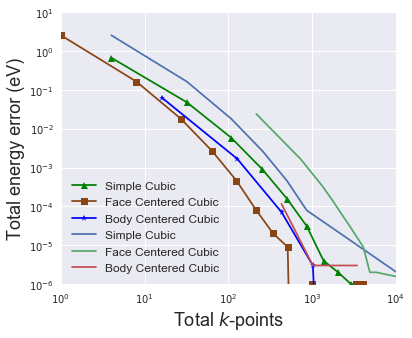

In [318]:
plt.figure(figsize=(6,5))
plt.plot(sc_full[:,0],sc_full[:,1],label="Simple Cubic",c='g',marker='^')
plt.plot(fcc_full[:,0],fcc_full[:,1],label="Face Centered Cubic",c='saddlebrown',marker='s')
plt.plot(bcc_full[:,0],bcc_full[:,1],label="Body Centered Cubic",c='b',marker='*')
plt.plot(sc[:,0],sc[:,1],label="Simple Cubic")
plt.plot(fcc[:,0],fcc[:,1],label="Face Centered Cubic")
plt.plot(bcc[:,0],bcc[:,1],label="Body Centered Cubic")
#plt.plot(m_j_ks_all[:,0],m_j_ks_all[:,1])
plt.yscale('log')
plt.xscale('log')
plt.ylim(1E-6,10)
plt.xlim(1E0,1E4)
plt.legend(fontsize=12)
#plt.grid()
#plt.title("Breakdown of Grid Type for K-grid",fontsize=22)
plt.ylabel("Total energy error (eV)",fontsize=18)
plt.xlabel("Total $k$-points",fontsize=18)
plt.savefig('/Users/wileymorgan/Desktop/Si_grid_type.pdf')
plt.show()

In [322]:
C_sc_full = []
C_bcc_full = []
C_fcc_full = []
C_all_grids = []

f = open('../data2/C_1/sc_conv.csv')
reader = csv.reader(f,delimiter='\t')
for row in reader:
    C_sc_full.append([int(row[0]),float(row[1])])
    if float(row[1]) > 1E-10:
        C_all_grids.append([int(row[0]),float(row[1])])
    
f = open('../data2/C_1/bcc_conv.csv')
reader = csv.reader(f,delimiter='\t')
for row in reader:
    C_bcc_full.append([int(row[0]),float(row[1])])
    if float(row[1]) > 1E-10:
        C_all_grids.append([int(row[0]),float(row[1])])
    
f = open('../data2/C_1/fcc_conv.csv')
reader = csv.reader(f,delimiter='\t')
for row in reader:
    C_fcc_full.append([int(row[0]),float(row[1])])
    if float(row[1]) > 1E-10:
        C_all_grids.append([int(row[0]),float(row[1])])
    
C_all_grids.sort(key=lambda x: x[0])
C_sc_full = np.array(C_sc_full)
C_bcc_full = np.array(C_bcc_full)
C_fcc_full = np.array(C_fcc_full)
C_all_grids = np.array(C_all_grids)

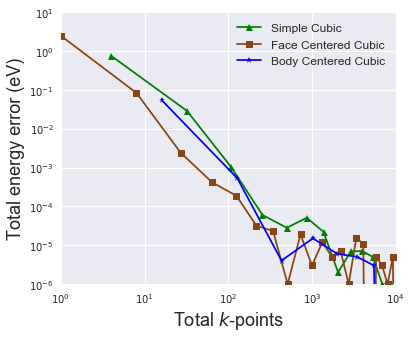

In [323]:
plt.figure(figsize=(6,5))
plt.plot(C_sc_full[:,0],C_sc_full[:,1],label="Simple Cubic",c='g',marker='^')
plt.plot(C_fcc_full[:,0],C_fcc_full[:,1],label="Face Centered Cubic",c='saddlebrown',marker='s')
plt.plot(C_bcc_full[:,0],C_bcc_full[:,1],label="Body Centered Cubic",c='b',marker='*')
plt.yscale('log')
plt.xscale('log')
plt.ylim(1E-6,10)
plt.xlim(1E0,1E4)
plt.legend(fontsize=12)
#plt.grid()
#plt.title("Breakdown of Grid Type for K-grid",fontsize=22)
plt.ylabel("Total energy error (eV)",fontsize=18)
plt.xlabel("Total $k$-points",fontsize=18)
plt.savefig('/Users/wileymorgan/Desktop/C_grid_type.pdf')
plt.show()

In [12]:
def get_mean_data_full(method,elements,sub_method=None):
    """Gathers the convergence data for the given method, element, 
    and sub-method, i.e. 'sc' for the Froyen method, and places it
    in a pandas dataframe where each column is a different cell 
    size and each row is a different k-point density. The dataframe also
    contains the mean error per density and numbder of instances 
    the density occures.
    
    Args:
        methad (str): "Froyen", "Mueller", or "Aflow"
        elements (list of str): A list consisting of the desired 
            elements ("V", "W", "Cu", "Al", "K", "Pd", "Ti", "Y", "Re")
        sub_method (str, optional): The sampling scheme for the 
            Froyen method ("sc", "bcc", "fcc", "hcp"). A sub_method is
            required for the Froyen method and for any other method
            this should be None.
    
    Returns:
        outdf (pandas.dataframe): A pandas dataframe of the error in
            the calculated energy at each density (row) and supercell 
            (column) in addition to a column of the average error per
            density.
    """
    for el in elements:
        if el in ["Ti","Y","Re"]:
            sizes = range(1,8)
        else:
            sizes = range(1,12)
            
        for i in sizes:
            data = [[0.0,0.0]]
            kpd = []
            if sub_method is None:
                f = open("../data2/{0}/{1}_conv/{2}_atom_kpd_conv.csv".format(method,el,i),"r")
            else:
                f = open("../data2/{0}/{1}_conv/{2}_{3}_atom_kpd_conv.csv".format(method,el,i,sub_method),"r")
            reader = csv.reader(f,delimiter='\t')
            for row in reader:
                if float(row[0]) in kpd and float(row[1]) != 0:
                    loc = kpd.index(float(row[0]))
                    data[loc][1] = (data[loc][1]+float(row[1]))/2.
                elif float(row[1]) != 0:
                    kpd.append(float(row[0]))
                    point = [float(row[0]),float(row[1])]
                    data.append(point)
                    
            data = np.array(data)
            if len(data) >= 1:
                df = pd.DataFrame(data[:,1:],index=data[:,0])#,columns=[str(i)+' atom'])    
            else:
                print("Method: {0}, element: {1}, size: {2}".format(method,el,i))
                
            if i > 1 or el != elements[0]:
                outdf = pd.concat([outdf,df], axis=1)
            else:
                outdf = df

    outdf['mean'] = outdf.mean(axis=1) 
    outdf['count'] = outdf.apply(lambda x: x.count(), axis=1)
    return outdf

In [33]:
hcp =["Ti","Y","Re"]
bcc = ["V","W","K"]
fcc = ["Al","Cu","Pd"]
metals = hcp+bcc+fcc
#F_metals = get_mean_data_full(metals,"Froyen")
#F_metals_scat = make_scatter_plot_data(F_metals)

#F_hcp = get_mean_data_full("Froyen",hcp,sub_method="hcp")
#F_hcp_scat = make_scatter_plot_data(F_hcp)
F_bcc = get_mean_data_full("Froyen",["K"],sub_method="bcc")
F_bcc_scat = make_scatter_plot_data(F_bcc)
F_fcc = get_mean_data_full("Froyen",["K"],sub_method="fcc")
F_fcc_scat = make_scatter_plot_data(F_fcc)
#F_sc = get_mean_data_full("Froyen",bcc+fcc,sub_method="sc")
#F_sc_scat = make_scatter_plot_data(F_sc)

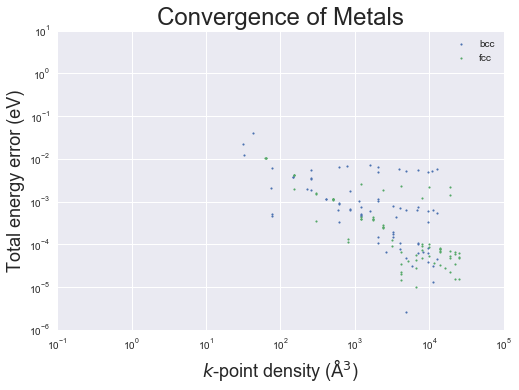

In [34]:
#plt.scatter(F_metals_scat[:,0],abs(F_metals_scat[:,1]),label="Froyen",marker="o",s=3,c='b')
#plt.scatter(F_hcp_scat[:,0],abs(F_hcp_scat[:,1]),label="hcp",marker="o",s=3)
plt.scatter(F_bcc_scat[:,0],abs(F_bcc_scat[:,1]),label="bcc",marker="o",s=3)
plt.scatter(F_fcc_scat[:,0],abs(F_fcc_scat[:,1]),label="fcc",marker="o",s=3)
#plt.scatter(F_sc_scat[:,0],abs(F_sc_scat[:,1]),label="sc",marker="o",s=3)
plt.ylabel("Total energy error (eV)",fontsize=18)
plt.xlabel("$k$-point density ($\mathrm{\AA}^{3}$)",fontsize=18)
plt.title("Convergence of Metals",fontsize=24)
plt.yscale('log')
plt.xscale('log')
plt.ylim(1E-6,1E1)
plt.xlim(1E-1,1E5)
plt.legend()
#plt.savefig("../plots/All_metals_comb.pdf")
plt.show()